In [1]:
import pandas as pd
import pandas as pd
from process_datant import DataProcessor
from prophet import Prophet
from sklearn.preprocessing import RobustScaler

# Loading the data
X_train = pd.read_csv('data/single_turbine_data_notemp/X_train.csv')
X_test = pd.read_csv('data/single_turbine_data_notemp/X_test.csv')
y_train = pd.read_csv('data/single_turbine_data_notemp/y_train.csv')
y_test = pd.read_csv('data/single_turbine_data_notemp/y_test.csv')

y_train['# Date and time'] = pd.to_datetime(y_train['# Date and time'])
y_test['# Date and time'] = pd.to_datetime(y_test['# Date and time'])

y_train.set_index('# Date and time', inplace=True)
y_test.set_index('# Date and time', inplace=True)

processor = DataProcessor(X_train)
processor.process_all()
X_train = processor.data

processor = DataProcessor(X_test)
processor.process_all()
X_test = processor.data

cols = [
   #  '1_Wind direction (°)', 
      #   '1_Nacelle position (°)',
      'avg_dir',
      # 'cos_wd',
      # 'cos_np',
      #  '1_Power (kW)', 
       '1_Generator RPM (RPM)', 
      #  '1_Wind direction (°)_change',
      #  '1_Nacelle position (°)_change', '1_Power (kW)_change',
      #  '1_Generator RPM (RPM)_change', 
      #  'curtailed', 
       'offline', 
       '1_Wind speed (m/s)',
       'avg_pitch_angle', 
       'cooling',
      #  '1_Wind direction (°)_rollmean',
      #  '1_Wind direction (°)_rollstd', 
      #  '1_Wind direction (°)_crest_factor',
      #  '1_Nacelle position (°)_rollmean', 
      #  '1_Nacelle position (°)_rollstd',
      #  '1_Nacelle position (°)_crest_factor', 
      #  '1_Power (kW)_rollmean',
      #  '1_Power (kW)_rollstd', 
      #  '1_Power (kW)_crest_factor',
      #  '1_Generator RPM (RPM)_rollmean', 
      #  '1_Generator RPM (RPM)_rollstd',
      #  '1_Generator RPM (RPM)_crest_factor', 
      #  '1_Wind direction (°)_lead6',
      #  '1_Nacelle position (°)_lead3', 
      #  '1_Power (kW)_lag6',
      #  '1_Generator RPM (RPM)_lead6', 
      #  'month_sin', 
      #  'month_cos', 
      #  'hour_sin',
      #  'hour_cos', 
       '1_Gear oil temperature (°C)', 
       '10_m_hws_mean_mps',
    #    '10_m_hwd_mean_deg-n_true', 
       '100_m_hws_mean_mps',
    #    '100_m_hwd_mean_deg-n_true', 
       '2_m_temp_mean_deg-c',
       '2_m_dew_point_temp_deg-c', 
    #    '2_m_rh_mean_%', 
    #    '0_m_pres_mean_pa',
    #    'sea_level_pres_mean_pa', 
    #    'boundary_layer_height_m',
       'total_cloud_cover_%', 
       'instantaneous_surface_sensible_heat_flux_wpm2',
       'friction_velocity_mps', 
    #    'cloud_base_height_m',
       'surface_solar_radiation_downwards_wpm2',
       ]

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

era = pd.read_csv('data/single_turbine_data_notemp/ERA5T.csv')
era['datetime_start_utc'] = pd.to_datetime(era['datetime_start_utc'])
era['datetime_start_utc'] = era['datetime_start_utc'].dt.tz_convert(None)
era.set_index('datetime_start_utc', inplace=True)
era = era.resample('10T').asfreq()
era = era.interpolate(method='linear')
train_data = pd.merge(train_data, era, left_on=train_data.index, right_on=era.index).set_index('key_0')
test_data = pd.merge(test_data, era, left_on=test_data.index, right_on=era.index).set_index('key_0')

train_data = train_data[cols]
test_data = test_data[cols]

all_data = pd.concat([train_data, test_data], axis=0)

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and wil

In [2]:
# promote index to column
train_data.reset_index(inplace=True)
# rename date column to ds
train_data.rename(columns={'key_0': 'ds', '1_Gear oil temperature (°C)': 'y'}, inplace=True)

In [3]:
def find_sequences(df, column, min_length=6):
    events = []
    count = 0
    trigger = False  # A flag to indicate if a sequence is active
    index_values = df.index.tolist()
    
    for i in range(len(df)):
        if df[column].iloc[i] == 1:
            count += 1
            if count >= min_length:
                if not trigger:  # To avoid duplicate entries for the same sequence
                    events.append(index_values[i - count + 1])
                    trigger = True
        else:
            count = 0
            trigger = False  # Reset flag when the sequence ends
    
    return pd.DataFrame({
        'holiday': column,
        'ds': pd.to_datetime(events),
    })

# Find sequences for 'offline' and 'curtailed'
offline_holidays = find_sequences(all_data, 'offline')
# curtailed_holidays = find_sequences(all_data, 'curtailed')
# cooling_holidays = find_sequences(all_data, 'cooling')

# Concatenate to create the final holidays DataFrame
holidays = pd.concat([offline_holidays])


In [4]:
model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=1.0, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, holidays=holidays, growth='logistic')
for col in cols:
    if col not in ['offline', 'curtailed', '1_Gear oil temperature (°C)', 'cooling']:
        model.add_regressor(col)
train_data['cap'] = 60
model.fit(train_data)
import pandas as pd

periods = len(test_data)
future = model.make_future_dataframe(periods=periods, freq='10min')

for col in cols:
    if col not in ['offline', 'curtailed', '1_Gear oil temperature (°C)', 'cooling']:
        concatenated_series = pd.concat([train_data[col], test_data[col].iloc[:periods]])

        future[col] = concatenated_series.reset_index(drop=True)
        future['cap'] = 60

# Perform prediction
fcst = model.predict(future)

15:32:04 - cmdstanpy - INFO - Chain [1] start processing
15:32:23 - cmdstanpy - INFO - Chain [1] done processing


In [7]:

# # Python
# import itertools
# import numpy as np
# import pandas as pd
# from prophet.diagnostics import performance_metrics
# from prophet.diagnostics import cross_validation

# param_grid = {  
#     'changepoint_prior_scale': [0.0001, 0.005, 0.001],
#     'seasonality_prior_scale': [1],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params)
#     for col in cols:
#         m.add_regressor(col)
#     m.fit(y_train)
#     df_cv = cross_validation(m, initial = '730 days', horizon='365 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [8]:
# rsme of last 300 points in fct against first 300 points in y_test

from sklearn.metrics import mean_squared_error

y_tested = y_test[:periods]
fcsted = fcst[-periods:]

mean_squared_error(y_tested['1_Gear oil temperature (°C)'], fcsted['yhat'], squared=False)

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

3.7780141397747014

: 

In [ ]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), model, fcst)

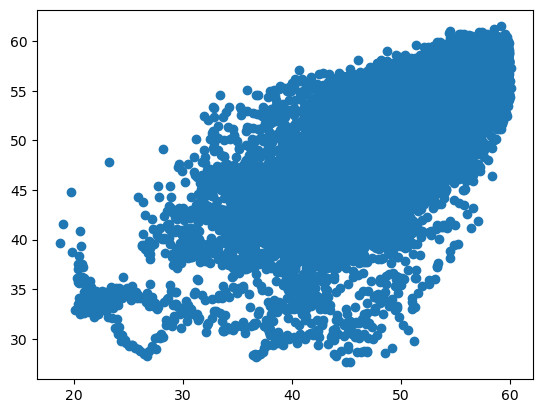

In [7]:
import matplotlib.pyplot as plt
plt.scatter(y_tested['1_Gear oil temperature (°C)'], fcsted['yhat'])

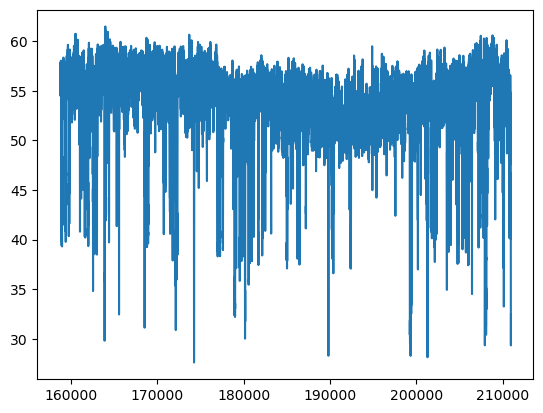

In [8]:
import matplotlib.pyplot as plt
plt.plot(fcsted['yhat'])

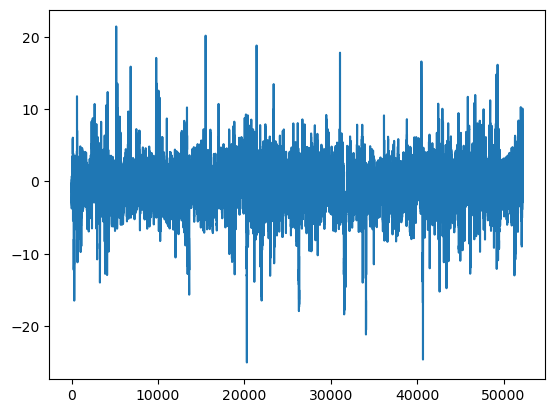

In [9]:
# plot the difference over time
plt.plot(range(len(y_tested['1_Gear oil temperature (°C)'])), y_tested['1_Gear oil temperature (°C)'].to_numpy() - fcsted['yhat'].to_numpy())

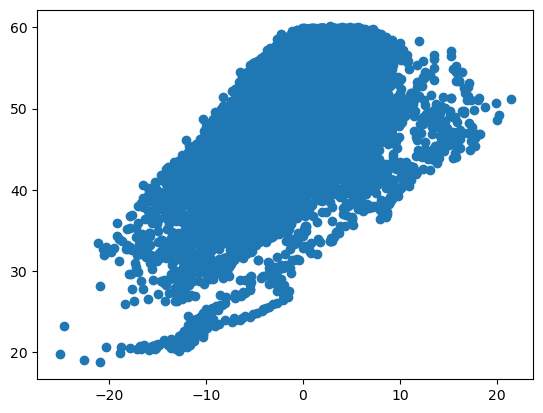

In [10]:
# plot the difference against the truth
plt.scatter(y_tested['1_Gear oil temperature (°C)'].to_numpy() - fcsted['yhat'].to_numpy(), y_tested['1_Gear oil temperature (°C)'])

((array([-4.20116808, -3.99587499, -3.88396845, ...,  3.88396845,
          3.99587499,  4.20116808]),
  array([-7.92067911, -7.09203564, -6.36716882, ...,  6.44759421,
          6.48057299,  7.71007966])),
 (0.9187084917571715, 0.04332724104605513, 0.9739139840973092))

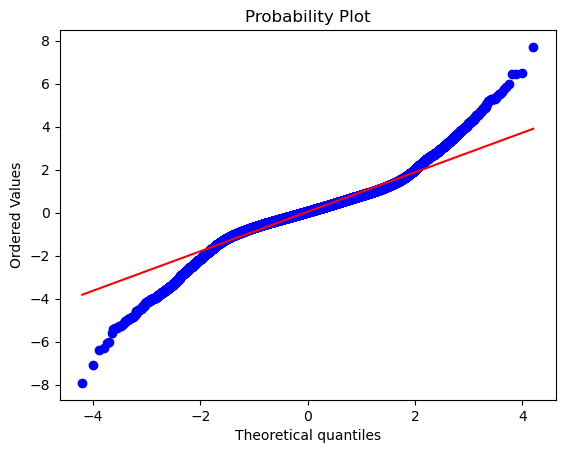

In [8]:
# qq plot
import scipy.stats as stats

stats.probplot(y_tested['1_Gear oil temperature (°C)'].to_numpy() - fcsted['yhat'].to_numpy(), dist="norm", plot=plt)